In [93]:
# HP-TES sizing
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date, time
import matplotlib.dates as mdates

## Define Peak Price and Peak load overlap (discharge time) and charge time

Lets say 12 - 6 pm is discharge 8pm to 10 am is charge

## Find HP Sizing Trapezoid

Points start in bottom right, and the perimeter of the sizing trapezoid is drawn clockwise from point 1 to point 2 to point 3, etc.

Notes:
USE CELL B AS REFERENCE or one without PCM
Could aggregate for multiple dates
Aggregation Methods:
 - Average multiple dates together, chosen visually
 - Select several of the highest max load days, average the trapezoids
    - highest max load NOT indicitive of overall peak loads.
 - Select several highest load days, average days then generate trapezoid
 - Select days with highest load DURING peak period
 - Select days with highest average of load and energy (during peak period or full day)


In [94]:
# times must be 2 digit strings, 24 hour format
charge_st = '20'
charge_et = '10'
charge_duration = 10
discharge_st = '12'
discharge_et = '20'

In [95]:
# formatting data
df = pd.read_csv('Cell 1A_1B Chilled Water Load -data-2022-09-30 00_41_29.csv', index_col= 'Time', parse_dates= True)
df.head()

,1A-Th-Chilled Water
Time,
2021-08-09 13:28:00,2.20 kW
2021-08-09 13:29:00,2.48 kW
2021-08-09 13:33:00,1.75 kW
2021-08-09 13:34:00,1.59 kW
2021-08-09 13:35:00,1.51 kW


In [96]:
def get_kW(str_val):
    str_splt = str_val.split(' ')
    if str_splt[1] == 'kW':
        return float(str_splt[0])
    elif str_splt[1] == 'W':
        return float(str_splt[0])/1000
    elif str_splt[1] == 'mW':
        return float(str_splt[0])/1000000
    elif str_splt[1] == 'µW':
        return float(str_splt[0])/1000000000  
    else:
        print(str_val)
        #return 0 
        raise(Exception('not kW or W or mW or µW'))


In [97]:
df['value'] = df['1A-Th-Chilled Water'].apply(get_kW)
df = df.drop(columns = '1A-Th-Chilled Water')
df.head()

,value
Time,
2021-08-09 13:28:00,2.20
2021-08-09 13:29:00,2.48
2021-08-09 13:33:00,1.75
2021-08-09 13:34:00,1.59
2021-08-09 13:35:00,1.51


In [98]:
groups = df.groupby(df.index.date)
mean_df = groups.mean()
day = mean_df.loc[mean_df['value'] == mean_df.max()[0]].index[0]

In [99]:
groups.get_group(date(2021,10,10))

,value
Time,
2021-10-10 00:00:00,0.474
2021-10-10 00:01:00,0.473
2021-10-10 00:02:00,0.469
2021-10-10 00:03:00,0.307
2021-10-10 00:04:00,0.275
...,...
2021-10-10 23:54:00,0.435
2021-10-10 23:55:00,0.438
2021-10-10 23:56:00,0.439


In [100]:
days = mean_df.sort_values(by = 'value', ascending=False).index[:7]

In [101]:
for i, group in groups:
    break

In [102]:
def average_days(df, days):
    df=df.reset_index()
    df['date']=df['Time'].dt.date
    df['time']=df['Time'].dt.time
    df_day = df.loc[df.date.isin(days)].groupby('time').mean().reset_index()
    df_day['Time'] = df_day['time'].apply(lambda x: datetime.combine(datetime.min.date(), x))
    df_day = df_day.set_index('Time')
    return df_day, datetime.min.date()

In [103]:
dfd, day = average_days(df, days)

In [104]:
dfd

,time,value
Time,,
0001-01-01 00:00:00,00:00:00,1.460000
0001-01-01 00:01:00,00:01:00,1.490000
0001-01-01 00:02:00,00:02:00,1.448333
0001-01-01 00:03:00,00:03:00,1.408333
0001-01-01 00:04:00,00:04:00,1.358667
...,...,...
0001-01-01 23:55:00,23:55:00,1.915857
0001-01-01 23:56:00,23:56:00,1.802000
0001-01-01 23:57:00,23:57:00,1.287500


In [105]:
dfd.index = dfd.time

In [106]:
dfd.loc[(dfd.index > time(23)) | (dfd.index< time(1)), 'value']

time
00:00:00    1.460000
00:01:00    1.490000
00:02:00    1.448333
00:03:00    1.408333
00:04:00    1.358667
              ...   
23:55:00    1.915857
23:56:00    1.802000
23:57:00    1.287500
23:58:00    1.668571
23:59:00    1.657143
Name: value, Length: 119, dtype: float64

In [107]:
peak_ser = df.loc[f'2021-10-09 {discharge_st}:00:00': f'2021-10-10 {discharge_et}:00:00', 'value']
peak_energy = peak_ser.sum()/60
#charge_energy = df.loc[f'2021-10-09 {charge_st}:00:00': f'2021-10-10 {charge_et}:00:00', 'value'].sum()/60

In [108]:
# Point 1 (B) - Size HP for Peak Load

''' 
HP Capacity (kW) is x axis, TES size (kWh) is y axis
Find peak load (kW) and make that the Heat Pump capacity without any TES
This is refered to as Point B
'''
# hp_size_max = df.max().value # not using peak day
hp_size_max = peak_ser.max() # using value in peak period
point_1 = (hp_size_max, 0)
print(point_1)

(6.24, 0)


In [109]:
# Point 2 (between A and B) - Size TES to reduce HP capacity

'''
Potentially unnecessary point

Possible intermediate size: 
    Full cooling load for single Peak price hour within discharge window
    Half the size 
'''
hp_size = 0.5 * hp_size_max

TES_size = peak_ser.loc[peak_ser - hp_size > 0].sum()/60 # load during peak period above what HP can provide

point_2 = (hp_size, TES_size)
print(point_2)



(3.12, 38.563833333333335)


In [110]:
# Point 3 (A) - Minimize HP capacity
'''
Energy needed during peak - HP Capacity * discharge time - TES size = 0 (all energy at peak satisfied) 
hp_size = peak_energy / (charge_time + discharge_time)

This is essentially the bottom line of the trapezoid
'''
size_reduction = -0.005
hp_size = hp_size_max 
for i in range(0,10000):
    # TES_size_prev = TES_size
    # hp_size_prev = hp_size
    hp_size = hp_size + size_reduction * i
    TES_size = peak_ser.loc[peak_ser - hp_size > 0].sum()/60

    if TES_size > (hp_size * charge_duration):
        break

    #size_reduction = (TES_size_prev - TES_size)/(hp_size_prev - hp_size)
point_3 = (hp_size,TES_size)


In [111]:
pd.date_range(datetime(1999,12,31,23), datetime(2000,1,1,23), freq = 'T')

DatetimeIndex(['1999-12-31 23:00:00', '1999-12-31 23:01:00',
               '1999-12-31 23:02:00', '1999-12-31 23:03:00',
               '1999-12-31 23:04:00', '1999-12-31 23:05:00',
               '1999-12-31 23:06:00', '1999-12-31 23:07:00',
               '1999-12-31 23:08:00', '1999-12-31 23:09:00',
               ...
               '2000-01-01 22:51:00', '2000-01-01 22:52:00',
               '2000-01-01 22:53:00', '2000-01-01 22:54:00',
               '2000-01-01 22:55:00', '2000-01-01 22:56:00',
               '2000-01-01 22:57:00', '2000-01-01 22:58:00',
               '2000-01-01 22:59:00', '2000-01-01 23:00:00'],
              dtype='datetime64[ns]', length=1441, freq='T')

In [112]:
datetime.strptime('2021-10-10', '%Y-%m-%d')

datetime.datetime(2021, 10, 10, 0, 0)

In [113]:
# Point 4 C - Find TES size to supply all energy during discharge window
''' 
peak energy = HP capacity * charge time
''' 
TES_size = peak_energy
hp_size = TES_size/charge_duration 
point_4 = (hp_size, TES_size)
print(point_4)


(5.664511708333334, 56.64511708333334)


In [114]:
pd.date_range(datetime(1999,12,31,23), datetime(2000,1,1,23-1,59), freq = 'T') 

DatetimeIndex(['1999-12-31 23:00:00', '1999-12-31 23:01:00',
               '1999-12-31 23:02:00', '1999-12-31 23:03:00',
               '1999-12-31 23:04:00', '1999-12-31 23:05:00',
               '1999-12-31 23:06:00', '1999-12-31 23:07:00',
               '1999-12-31 23:08:00', '1999-12-31 23:09:00',
               ...
               '2000-01-01 22:50:00', '2000-01-01 22:51:00',
               '2000-01-01 22:52:00', '2000-01-01 22:53:00',
               '2000-01-01 22:54:00', '2000-01-01 22:55:00',
               '2000-01-01 22:56:00', '2000-01-01 22:57:00',
               '2000-01-01 22:58:00', '2000-01-01 22:59:00'],
              dtype='datetime64[ns]', length=1440, freq='T')

In [115]:
# Point 5 (D) - Maximum TES Size and maximum HP size

##  Class/Functions for plotting

In [116]:
class HP_sizer():

    def __init__(self, file, charge_p, discharge_p, day = None, index_col = 'Time', method = 'highest_ave'):
        df = pd.read_csv(file, index_col= index_col, parse_dates= True)
        #should be preprocessing
        df['value'] = df['1A-Th-Chilled Water'].apply(self.parse_val_string)
        df = df.drop(columns = '1A-Th-Chilled Water')
      
        # TODO: getting charge series and discharge series can all be one method
        self.df = self.get_df(df, day, method)
        self.charge_ser = self.get_period(self.df, charge_p)
        self.peak_ser = self.get_period(self.df, discharge_p)
       
        self.peak_energy = self.peak_ser.sum()/60


        self.hp_size_max = self.peak_ser.max() # probably shouldn't get this from peak series, should be from whole day

        self.charge_p = charge_p
        self.discharge_p = discharge_p

        self.point_1 = (self.hp_size_max, 0)

    def get_df(self, df, day, method):
        # Can try different aggregation methods here
        groups = df.groupby(df.index.date)
        if day:
            day = datetime.strptime(day, '%Y-%m-%d').date()
            df = groups.get_group(day)
            df.index = df.index.time
        elif method == 'peak_load':
            day = df.loc[df['value'] == df['value'].max()].index[0].date
            df = groups.get_group(day)
            df.index = df.index.time
        # Highest average load
        elif method == 'highest_ave':
            mean_df = groups.mean()
            day = mean_df.loc[mean_df['value'] == mean_df.max()[0]].index[0]
            df = groups.get_group(day)
            df.index = df.index.time
        #Average of 7 highest load days
        elif method == 'highest_7_days':
            groups = df.groupby(df.index.date)
            mean_df = groups.mean()
            days = mean_df.sort_values(by = 'value', ascending=False).index[:7]
            df = self.average_days(df, days)
            print(f'df represents days {days}')
        return df
    
    def average_days(self, df, days):
        df=df.reset_index()
        df['date']=df['Time'].dt.date
        df['time']=df['Time'].dt.time
        df_day = df.loc[df.date.isin(days)].groupby('time').mean()
        return df_day

    def get_period(self, df, period):
        if period[0] > period[1]:
            return df.loc[(df.index >= time(period[0])) | (df.index < time(period[1])), 'value']
        else:
            return df.loc[time(period[0]): time(period[1]), 'value']
        #should have error if period is the same hour

    def _tes_size(self, hp_size):
        # should add something to make sure load is ALWAYS satisfied
        # return hp_size * (self.charge_p[1] - self.charge_p[0] + 24)# engineering estimation, HP size * duration of charge
        return (hp_size - self.charge_ser).sum()/60 # ALL unused HP capacity goes to TES

    def sizing_plot(self):
        x, y = self._bottom()
        x2,y2= self._top()
        x3,y3 = self._right()
        plt.plot(x,y)
        plt.plot(x2,y2)
        plt.plot(x3,y3)
        plt.xlabel('HP Capacity (kW)')
        plt.ylabel('TES Size (kWh)')
        plt.show()
    
    # def plot_series(self, ser):
    #     plt.ylabel('kW')
    #     # plt.ylim(ymin = 0, ymax=self.ymax)
    #     plt.plot(ser)
    #     t_fmt = mdates.DateFormatter('%H:%M')
    #     plt.gca().xaxis.set_major_formatter(t_fmt)
    # #       plt.xticks(rotation=45)
    #     plt.show()


    def _bottom(self):

        hp_size = self.hp_size_max
        size_reduction = -0.0005 

        x = []
        y = []
        for i in range(0,100000):
        
            hp_size = hp_size + size_reduction * i
            TES_size = self.peak_ser.loc[self.peak_ser - hp_size > 0].sum()/60

            x.append(hp_size)
            y.append(TES_size)

            if TES_size > self._tes_size(hp_size):
                break
            
        self.point_2 = (hp_size,TES_size)

        return x, y

    def _top(self):
        # MUST run bottom before top
        x = []
        y = []
        hp_size = self.hp_size_max
        size_reduction = -0.0005 

        for i in range(0,100000):
            hp_size = hp_size + size_reduction * i

            # may want to draw top, then another line for the maximum based on peak energy provided by TES
            TES_size = self._tes_size(hp_size) # should subtract load in this period to make better estimate

            if TES_size > self.peak_energy:
                y.append(self.peak_energy)
            else:
                y.append(TES_size)
            x.append(hp_size)

            if hp_size <= self.point_2[0]: # This is cheating a bit
                break
            
        return x, y

    def _right(self):
        # This whole function is cheaty
        x = []
        y = []

        x.append(self.point_1[0])
        x.append(self.point_1[0])

        y.append(self.peak_energy)
        y.append(0)

        return x,y 
            

    def parse_val_string(self, str_val):
        str_splt = str_val.split(' ')
        if str_splt[1] == 'kW':
            return float(str_splt[0])
        elif str_splt[1] == 'W':
            return float(str_splt[0])/1000
        elif str_splt[1] == 'mW':
            return float(str_splt[0])/1000000
        elif str_splt[1] == 'µW':
            return float(str_splt[0])/1000000000  
        else:
            print(str_val)
            #return 0 
            raise(Exception('not kW or W or mW or µW'))

In [117]:
hps = HP_sizer('Cell 1A_1B Chilled Water Load -data-2022-09-30 00_41_29.csv', charge_p=(20,8), discharge_p=(12,19)) # specify date range?

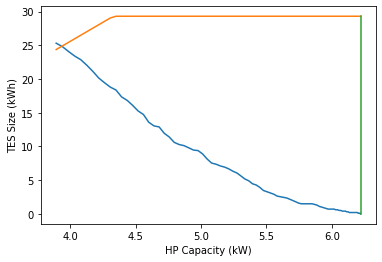

In [118]:
hps.sizing_plot()

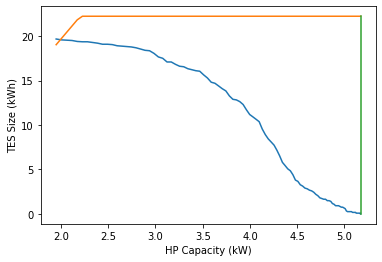

In [119]:
hps = HP_sizer('Cell 1A_1B Chilled Water Load -data-2022-09-30 00_41_29.csv', charge_p=(20,10), discharge_p=(12,20), day = '2021-10-10') # specify date range?
hps.sizing_plot()

df represents days Index([2021-10-05, 2021-10-03, 2021-10-01, 2021-09-14, 2021-10-02, 2021-10-04,
       2021-09-21],
      dtype='object')


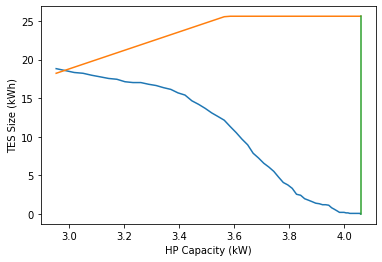

In [120]:
hps = HP_sizer('Cell 1A_1B Chilled Water Load -data-2022-09-30 00_41_29.csv', charge_p=(20,8), discharge_p=(11,19), method = 'highest_7_days') # specify date range?
hps.sizing_plot()